# PHY480/905 Semester Project 

### &#9989; Jonathan Kho

#### &#9989; Last Updated on 4/19/23

# Modeling advection in 1D


##  Introduction 

For my final project for PHY 480, I'm seeking to better understand and model advection in 1D. My interest in this project was piqued following some results from my independent research. I've been modeling a neutron star crust in 1D using the stellar evolution code dStar (which is very similar to MESA, and is written in fortran), and simulating a new type of thermonuclear explosion deep in the crust that was proposed last year. Following simulations of this explosion, I discovered that the entire outer crust of the star melts, which would lead to convective and advective processes. As I understand it, convection is very, very difficult to model numerically, so I'm seeking to understand how advection is done numerically, especially for the 1D case. 

Questions to answer:

- How is hydrodynamics modeled in code (at the basic level)
- What numerical approximations are used to approximate advection?
- How accurate are numerical hydrodynamic simulations at the 1D level?
- How do different compositions (molecular weight), temperatures affect fluid mechanics?
- What sets the convergence/stability for this code?

## Methodology

The basic premise behind modeling fluid mechanics (used here at least) is to discretize some differential equation that describes the advection process, generate a grid along an axis (a number line) with N cells that will store information about the fluid at that location, and then initialize some density distribution along the axis and iteratively update the cell's information according to the differential equation. 

The advection equation is as follows:
\begin{equation}
    \frac{\partial q(x,t)}{\partial t} + \frac{\partial q(x,t)v(x,t)}{\partial x} = s(x,t,q)
\end{equation}

where $q = \rho$ is some density (for example, mass density), and $s = 0$ for the advective equation for conservation of mass, and $q = \rho v$ and $s = -\frac{\partial p}{\partial x} + \rho f$ for the conservation equation of momentum. 

Explicitly, these equations are

\begin{equation}
    \frac{\partial \rho}{\partial t} + \frac{\partial \rho v}{\partial x} = 0
\end{equation}

\begin{equation}
    \frac{\partial \rho v}{\partial t} + \frac{\partial \rho v^2 + P}{\partial x} = \rho f
\end{equation}

where the pressure P is $P = \rho c_s^2$, and $c_s$ is the isothermal speed of sound: $c_s = \sqrt{\frac{k_B T}{\mu m_p}}$.

In order to numerically model these equations, we discretize them as follows:

\begin{equation}
    \frac{q_i^{n+1} - q_i^n}{t_n+1 - t_n} +v_0\frac{q_{i+1}^n - q_{i-1}^n}{x_{i+1} - x_{i-1}} = 0 
\end{equation}

for the ith cell location and the nth time step.

This allows us to solve for $q_i^{n+1}$:

\begin{equation}
    q_i^{n+1} =  q_i^n - v_0(t_{n+1} - t_n)\frac{q_{i+1}^n - q_{i-1}^n}{x_{i+1} - x_{i-1}}
\end{equation}

I began investigating the above questions by first investigating what code already has been written on this subject and what I can learn from the current literature. On the website cited in the cell below, I found the following snipet of code that demonstrated a naive implementation of an advective code:

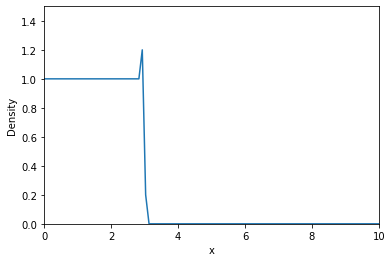

In [1]:
# Naive method
# Credit to: https://www.ita.uni-heidelberg.de/~dullemond/lectures/studtage_compastro_2018/index.shtml?lang=en
# I did not write this; I simply animated the movie in the notebook.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

nx   = 100
nt   = 100
x    = np.linspace(0.,10.,nx)
t    = np.linspace(0.,10.,nt)
q    = np.zeros((nt,nx))
q[0,x<3] = 1.0     # Step function initial condition
v0   = 0.4         # Constant fluid velocity

for n in range(0,nt-1):
    dt          = t[n+1] - t[n]
    q[n+1,1:-1] = q[n,1:-1] - dt * v0 * ( q[n,2:] - q[n,:-2] ) / ( x[2:] - x[:-2] )
    q[n+1,0]    = q[n,0]
    q[n+1,-1]   = q[n,-1]

n = 0
def animupdate(frameNum, a0):
    global n,q,x,nt
    y = q[n,:]
    a0.set_data(x, y)
    n = (n + 1) % nt
    # return a0,

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.5))
a0, = ax.plot([], [])
plt.xlabel('x')
plt.ylabel('Density')
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)
anim.save('naiveadvection.mp4', writer = 'ffmpeg', fps = 30)

HTML(anim.to_html5_video())

As can be seen above, this naive method results in exponentially increasing oscillations in the density that are very unphysical. This comes about because when we use the discretization above, we want to update our ith cell differently if mass is flowing into it from the left or the right; that is, if our fluid velocity $v_0$ is positive or negative. One solution to this problem is to simply create two cases where you change your updated value for the ith cell depending on whether mass is flowing from the i-1 cell or the i+1 cell. This is called the "upwind" method becuase we are updating our cells "upwind" - in the direction of fluid moton. 

To do this, I began by creating my own grid class that would store values for each spatial cell and each time step, and that could be used in my advection function. I then wrote an upwind advection function to solve for the fluid's density distribution as a function of time:

In [2]:
# Creating a basic grid:

class grid():
    
    '''
    
    Grid class to be used for advection
    
    Inputs:
    
    xsize - physical length of our board/number of cells
    tmax - number of time steps we will be taking 
    
    '''
    
    def __init__(self,xsize,tmax): # Our grid will have 2 dimensions: 1 for space and 1 for time
        
        self.vals = np.zeros((tmax,xsize))
        
    def initialize(self,vals): # Set the initial values of our grid
    
        self.vals[0,:] = vals
    
    def get_vals(self): # Return the values in our grid
        
        return(self.vals)
    
    def update(self,loc,new_vals): # Update the values in our grid at the loc specified
        
        self.vals[loc] = new_vals
        
        
# Creating my simple advection function using the upwind method:

def solve_adv(vals, C = 0.1,v0 = 1,tfactor = 1):
    
    '''
    
    Function for solving advection using the upwind method
    
    Inputs:
    
    vals - inital density values for the board
    C - time constraint that controls size of dt and convergence
    v0 - speed of fluid; I model the fluid as moving laminarly for ease of implementation
    tfactor - allows the user to scale the time of the simulation by
    
    Output:
    
    board - Board object containing the fluid density for all time steps 
    
    '''
    
    xsize = len(vals)       # Store x size of board
    dx = (1/xsize)          # Taking even step sizes dx
    dt = C*dx/v0            # Calculating our dt steps from our C value, see explanation below!
    tmax = tfactor*xsize/v0 # Optional scaling of time
    tlength = int(tmax/dt)  # Calculate our time length for board
    
    board = grid(xsize,tlength) # Initialize our grid accoding to the dimensions just found
    board.initialize(abs(vals)) # Ensuring all positive values
        
    for t in range(tlength-1):  # Iterate over all our time steps
        
        vals = board.get_vals() # Store our update values in vals
        
        for i in range(xsize):  # Iterate across all x values
            
            if v0 > 0: # Our updated values will change depending on which way our fluid is flowing
                # The modulus here is to be careful not to index past the size of our board:
                updated_val = vals[t,i] - C * ( vals[t,i] - vals[t,(i-1)] ) # See disussion below for the index changes
                board.update((t+1,i),updated_val) 
                
            elif v0 < 0:
                # If our fluid is flowing backwards, we want to check the difference with our i-1 cell
                updated_val = vals[t,i] - C * ( vals[t,i] - vals[t,(i+1)%xsize] )
                board.update((t+1,i),updated_val) 

    return(board)

Let's see how our code does! We create an initial sinusoidal density distribution, which may not be very physical but will certainly look interesting and will tell us whether our code is working as expected.

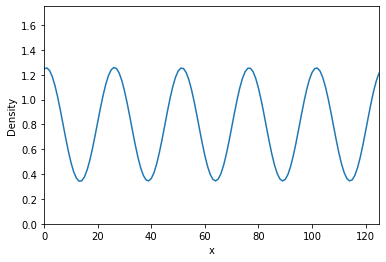

In [3]:
x = np.arange(0,2*np.pi,0.05) 
y = 0.8 + 0.8*np.sin(5*x)      # Initializing some sinusoidal density function

board = solve_adv(y,v0 = 10,tfactor = 1) # Starting with a positive velocity

vals = board.get_vals()

n = 0
nt = len(vals)
x = np.arange(len(vals[0]))

def animupdate(frameNum, a0):
    global n,vals,x,nt
    y = vals[n,:]
    a0.set_data(x, y)
    n = (n + 1) % nt
    # return a0,

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.75))
a0, = ax.plot([], [])
plt.xlabel('x')
plt.ylabel('Density')
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)
anim.save('forwardadvection.mp4', writer = 'ffmpeg', fps = 30)

HTML(anim.to_html5_video())

Our code works! As we can see above, the fluid collectively moves at a certain velocity $v_0$, and while it moves, the peaks and troughs begin to smoothen out as the fluid advects. We can see that this function also works for negative velocities:


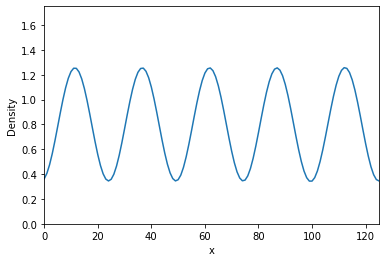

In [4]:
board = solve_adv(y,v0 = -10,tfactor = 1) # Changing our velocity to be negative now

vals = board.get_vals()

n = 0
nt = len(vals)
x = np.arange(len(vals[0]))

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.75))
a0, = ax.plot([], [])
plt.xlabel('x')
plt.ylabel('Density')
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)
anim.save('backwardadvection.mp4', writer = 'ffmpeg', fps = 30)

HTML(anim.to_html5_video())

So why does our density profile smooth out? We can find the answer easily examining our discretized equation:

\begin{equation}
    q_i^{n+1} =  q_i^n - v_0(t_{n+1} - t_n)\frac{q_{i+1}^n - q_{i-1}^n}{x_{i+1} - x_{i-1}}
\end{equation}

For the upwind method, the above becomes two cases:

For $v_0 > 0$:

\begin{equation}
    q_i^{n+1} =  q_i^n - |v_0|(t_{n+1} - t_n)\frac{q_{i}^n - q_{i-1}^n}{x_{i+1} - x_{i}}
\end{equation}

For $v_0 < 0$:

\begin{equation}
    q_i^{n+1} =  q_i^n - |v_0|(t_{n+1} - t_n)\frac{q_{i}^n - q_{i+1}^n}{x_{i+1} - x_{i}}
\end{equation}

Here, the indices of the x's aren't too important for me, as each $\Delta x$ is the same as long as we are looking at the difference from i to i + 1. The difference in the two equations is subtle, but important. For positive velocities, we want to know whether the i-1 cell has more mass in it than the ith cell. If it does, (i.e. if $q_{i}^n - q_{i-1}^n < 0$) then our ith cell will gain mass, since our fluid is moving in the +i direction. The opposite is also true: if there is more mass in the ith cell than the i-1 cell, the difference $q_{i}^n - q_{i-1}^n$ will be positive, and our updated value for $q_i^{n+1}$ will be smaller than $q_i^{n}$. The same reasoning can be applied to negative velocities, and our equation above has been changed to reflect this. 

Now, I've been a little sneaky in how I developed my advection code, and this was on purpose. In the above function, I didn't write out the discretized equations exactly. Instead, I used a parameter C to serve as the factor that determined how big of a step the code takes, where $C = v_0\frac{dt}{dx}$. This is a dimensionless variable, and is used to ensure that we don't lose information when we are iterating. The reason this is important is because if our fluid is moving at some velocity $v_0$ that is faster than how quickly we are iterating across our cells ($\frac{dt}{dx}$), then we want to reduce our time step dt so we don't have mass moving from the i-2 cell into the ith cell (our algorithm assumes this isn't happening, and that mass transfer only occurs between adjacent cells). This can be controlled by keeping C sufficiently small and calculating our dt's from it, however we can also see how quickly our code becomes unphysical if C becomes too large:

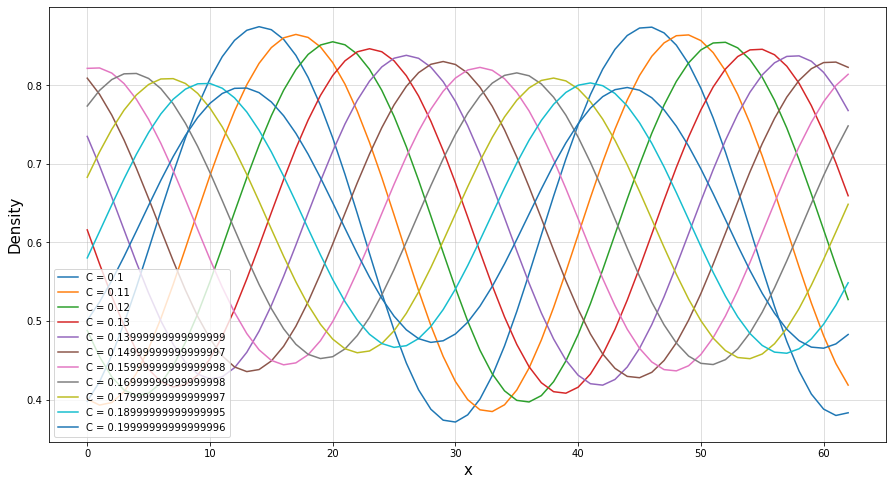

In [5]:
# Testing C parameter for stability:

x = np.arange(0,2*np.pi,0.1)
y = np.sin(x)

Cs = np.arange(0.1,0.21,0.01)

solns = []

for i in range(len(Cs)):
    soln = solve_adv(vals = y,C = Cs[i])
    solns.append(soln.get_vals()[300,:]) # Picking the 300th state in the simulation
    
x = np.arange(len(solns[0]))
plt.figure(figsize = (15,8))
for i in range(len(solns)):
    plt.plot(x,solns[i],label = 'C = {}'.format(Cs[i]))
    
plt.legend()
plt.xlabel('x',size = 15)
plt.ylabel('Density',size = 15)
plt.grid(alpha = 0.5)
# plt.savefig('C_variations_upwind')

The above plot clearly shows the wide diversity in solutions that we get when C becomes incrementally larger. Changing C by just 0.01 gives us a significantly different solution than we previously had. In the above plot, we can also see how increasing C gives us solutions with smaller and smaller amplitudes. This is a numerical artifact from the fluid "jumping" ahead past our dx's and artificially smoothing out our function.

Now, we have a functioning 1D advection code, but it isn't all that interesting at the moment. Let's consider what happens to our fluid when we change its composition or temperature. This will be reflected by taking into account equation (3), and adding the pressure term into our calculations (we will still consider our external force/acceleration f to be 0). We start from (3) and work our way to a new expression for $q_{i}^{n+1}$:

Equation (3):

\begin{equation}
    \frac{\partial \rho v}{\partial t} + \frac{\partial \rho v^2 + P}{\partial x} = \rho f
\end{equation}



\begin{equation}
    \frac{\partial \rho v}{\partial t} + \frac{\partial \rho v^2 }{\partial x} = -\frac{\partial P}{\partial x}
\end{equation}

for f = 0.

Discretizing: 

$$ v_0\frac{q_i^{n+1} - q_i^n}{t_{n+1} - t_n} +v_0^2\frac{q_{i+1}^n - q_{i-1}^n}{x_{i+1} - x_{i-1}} = -\frac{P_{i+1}^n - P_i^n}{x_{i+1} - x_i} $$

$$v_0\frac{q_i^{n+1} - q_i^n}{t_{n+1} - t_n} = -\frac{(P_{i+1}^n - P_i^n) + v_0^2(q_{i+1}^n - q_{i-1}^n)}{x_{i+1} - x_i}$$

$$q_i^{n+1} =  q_i^n - \frac{(t_{n+1} - t_n)}{v_0}\frac{c_s^2(q_{i+1}^n - q_{i-1}^n) + v_0^2(q_{i+1}^n - q_{i-1}^n)}{x_{i+1} - x_{i-1}}$$

\begin{equation}
    q_i^{n+1} =  q_i^n - \frac{(t_{n+1} - t_n)}{v_0(x_{i+1} - x_{i-1})}(c_s^2 + v_0^2)(q_{i+1}^n - q_{i-1}^n)
\end{equation}

We now have a new expression for our updated density values that take into account pressure, which involves the sound crossing speed. In my code, the algorithm looks a little different than what we have above because I introduce the C constant: 

\begin{equation}
    q_i^{n+1} =  q_i^n - C\frac{(c_s^2 + v_0^2)}{v_0^2}(q_{i+1}^n - q_{i-1}^n)
\end{equation}

Now, when I tried to implement this, my density plots quickly blew up. The scalings for $c_s$ and $v_0$ were wildly different such that the updated values for my plots were much greater than the original values themselves, and I got extremely large and unphysical oscillations. This could theoretically be fixed by setting the temperature, fluid velocity, and mean molecular weight to extreme conditions until our sound crossing speed is of the same order of magnitude as $v_0$, but what I'm really interested in is how the fluid motion scales with the composition and temperature. Recalling that $c_s = \sqrt{\frac{k_B T}{\mu m_p}}$, if we just pay attention to the T and $\mu$ scalings, our simplified result is 

\begin{equation}
    q_i^{n+1} =  q_i^n - C\frac{(\frac{T}{\mu} + v_0^2)}{v_0^2}(q_{i+1}^n - q_{i-1}^n)
\end{equation}

Now, we are free to vary T and $\mu$ and see how the fluid responds!

In [6]:
# Implementing pressure and different molecular weight/temperature

def advanced_adv(vals, C = 0.1,v0 = 100,tfactor = 1,mu = 1,T = 1): 
    
    xsize = len(vals)
    dx = (1/xsize) # Taking even step sizes dx
    dt = C*dx/v0 # Calculating our dt steps from our C value
    tmax = tfactor*xsize/v0
    tlength = int(tmax/dt)
    
    # kB = 1.38e-23 # Boltzmann's constant
    # mp = 1.67e-27 # Proton mass
    # cs2 = kB*T/(mu*mp) Actual sound crossing speed, but only interested in T, mu scalings
    cs2 = T/mu # Sound-crossing speed squared, relevant for pressure term. Here I've ignored the other constants
    
    board = grid(xsize,tlength)
    board.initialize(abs(vals)) # Ensuring all positive values
        
    for t in range(tlength-1):
        
        vals = board.get_vals()
            
        for i in range(xsize):
            
            if v0 > 0: # We still use the upwind method here!
                # The modulus here is to be careful not to index past the size of our board:
                updated_val = vals[t,i] - C * (cs2 + v0**2)/v0**2 * ( vals[t,i] - vals[t,(i-1)] ) 
                board.update((t+1,i),updated_val) 
                
            elif v0 < 0:
                # If our fluid is flowing backwards, we want to check the difference with our i-1 cell
                updated_val = vals[t,i] - C * (cs2 + v0**2)/v0**2 * ( vals[t,i] - vals[t,(i+1)%xsize] )
                board.update((t+1,i),updated_val)

    return(board)

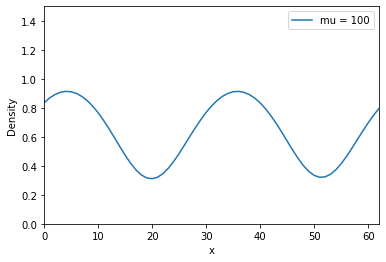

In [7]:
# Varying mu

x = np.arange(0,2*np.pi,0.1)
y = np.sin(x)
mu1 = 100 # Testing fluid motion for large mu

board = advanced_adv(y,v0 = 10,mu = mu1)

vals = board.get_vals()

n = 0
nt = len(vals)
x = np.arange(len(vals[0]))

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.5))
a0, = ax.plot([], [],label = 'mu = {}'.format(mu1))
plt.legend()
plt.xlabel('x')
plt.ylabel('Density')
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)
anim.save('muadvection100.mp4', writer = 'ffmpeg', fps = 30)

HTML(anim.to_html5_video())

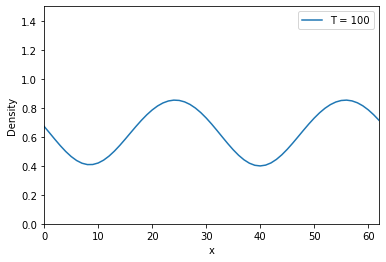

In [8]:
# Varying T

x = np.arange(0,2*np.pi,0.1)
y = np.sin(x)
T1 = 100 # Testing fluid motion for large T

board = advanced_adv(y,v0 = 10,T = T1)

vals = board.get_vals()

n = 0
nt = len(vals)
x = np.arange(len(vals[0]))

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.5))
a0, = ax.plot([], [],label = 'T = {}'.format(T1))
plt.legend()
plt.xlabel('x')
plt.ylabel('Density')
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)
anim.save('Tadvection100.mp4', writer = 'ffmpeg', fps = 30)

HTML(anim.to_html5_video())

Varying the composition and temperature have the expected results on our fluid, which we can simply read off of our equation. Increasing $\mu$ causes the fluid to advect more slowly, which makes sense because it is heavier and should respond more slowly to perturbations. Increasing T causese the fluid to advect much more quickly, which is also expected. The fluid is more energetic and quicker to respond to perturbations, hence the positive correlation with the sound crossing speed.

In order to obtain a more analytical/numerical analysis of how these parameters affect the fluid, let's record how long it takes our fluid to dissipate to a maximum density of 0.7 for a range of different $\mu$'s and T's:

In [9]:
mus = np.arange(1,100,10) # mus we want to investigate
itosmallmu = []

for i in range(len(mus)):
    
    board = advanced_adv(y,v0 = 10,mu = mus[i])
    vals = board.get_vals()
    
    ii = 0
    
    while max(vals[ii]) > 0.7: # We want to stop when the amplitude reaches 0.7
        
        ii += 1
    
    itosmallmu.append(ii)

In [10]:
Ts = np.arange(1,100,10) # Ts we want to investigate
itosmallT = []

for i in range(len(Ts)):
    
    board = advanced_adv(y,v0 = 10,T = Ts[i])
    vals = board.get_vals()
    
    ii = 0
    
    while max(vals[ii]) > 0.7: # Same stopping condition as the mu's had
        
        ii += 1
    
    itosmallT.append(ii)

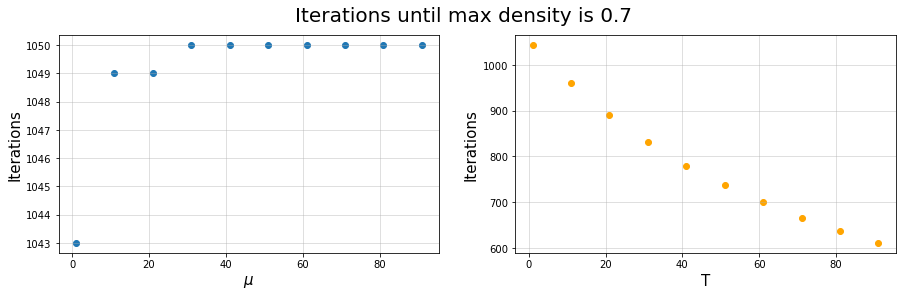

In [11]:
plt.figure(figsize = (15,4))
plt.suptitle('Iterations until max density is 0.7',size = 20)

plt.subplot(121)
plt.scatter(mus,itosmallmu)
plt.xlabel('$\mu$',size = 15)
plt.ylabel('Iterations',size = 15)
plt.grid(alpha = 0.5)

plt.subplot(122)
plt.scatter(Ts,itosmallT,c = 'orange')
plt.xlabel('T',size = 15)
plt.ylabel('Iterations',size = 15)
plt.grid(alpha = 0.5)

#plt.savefig('Iterations_plot')

I recognize that these values for T are extreme in some cases and wouldn't be encountered naturally, but again, the shape and general behavior of the plot is what I'm more interested in. I discuss the consequences of these plots below.

## Results and Discussion

We started off with the naive method. As seen below, this method is not physical, and needed adjusting.

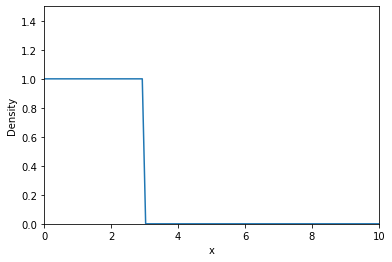

In [12]:
# Showing the naive method again:

nx   = 100
nt   = 100
x    = np.linspace(0.,10.,nx)
t    = np.linspace(0.,10.,nt)
q    = np.zeros((nt,nx))
q[0,x<3] = 1.0     # Step function initial condition
v0   = 0.4         # Constant fluid velocity

for n in range(0,nt-1):
    dt          = t[n+1] - t[n]
    q[n+1,1:-1] = q[n,1:-1] - dt * v0 * ( q[n,2:] - q[n,:-2] ) / ( x[2:] - x[:-2] )
    q[n+1,0]    = q[n,0]
    q[n+1,-1]   = q[n,-1]

n = 0
def animupdate(frameNum, a0):
    global n,q,x,nt
    y = q[n,:]
    a0.set_data(x, y)
    n = (n + 1) % nt
    # return a0,
    
fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.5))
a0, = ax.plot([], [])
plt.xlabel('x')
plt.ylabel('Density')
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)

HTML(anim.to_html5_video())

In order to fix the naive method, I implemented the upwind method and produced the following plots, establishing that the code works for both positive and negative velocities. 

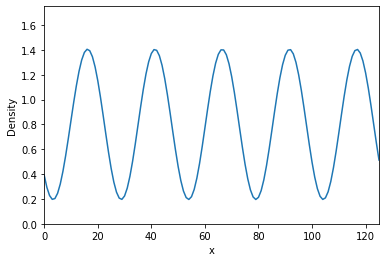

In [13]:
x = np.arange(0,2*np.pi,0.05)
y = 0.8 + 0.8*np.sin(5*x)

def animupdate(frameNum, a0):
    global n,vals,x,nt
    y = vals[n,:]
    a0.set_data(x, y)
    n = (n + 1) % nt
    # return a0,

board = solve_adv(y,v0 = 10,tfactor = 1)

vals = board.get_vals()

n = 0
nt = len(vals)
x = np.arange(len(vals[0]))

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.75))
a0, = ax.plot([], [])
plt.xlabel('x')
plt.ylabel('Density')
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)

HTML(anim.to_html5_video())

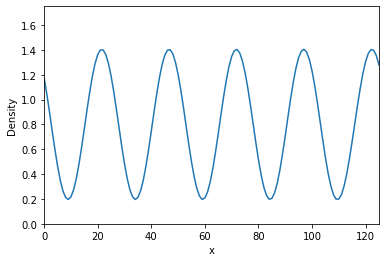

In [19]:
x = np.arange(0,2*np.pi,0.05)
y = 0.8 + 0.8*np.sin(5*x)
board = solve_adv(y,v0 = -10,tfactor = 1)

vals = board.get_vals()

n = 0
nt = len(vals)
x = np.arange(len(vals[0]))

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.75))
a0, = ax.plot([], [])
plt.xlabel('x')
plt.ylabel('Density')
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)

HTML(anim.to_html5_video())

This in and of itself is an interesting result: if you simply follow the equations and try to directly implement them as is into an algorithm, it fails! This is not an obvious result, and is really only seen after one tries to develop a hydro code the naive way. Beyond this, however, I also analyzed the conditions for which my code stays physical (convergence conditions). The parameter I adjusted for this was the C parameter, which controlled how long of a time step we took relative to the fluid velocity and the grid spacing we chose:

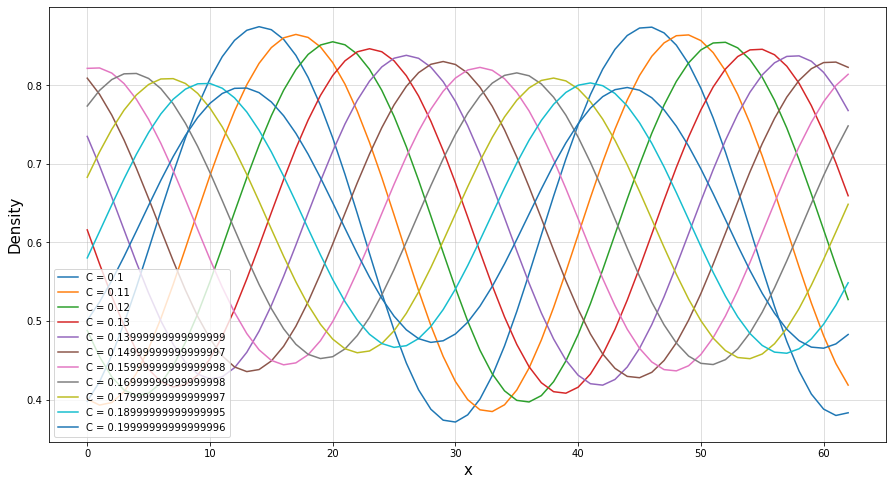

In [14]:
x = np.arange(0,2*np.pi,0.1)
y = np.sin(x)

Cs = np.arange(0.1,0.21,0.01)

solns = []

for i in range(len(Cs)):
    soln = solve_adv(vals = y,C = Cs[i])
    solns.append(soln.get_vals()[300,:]) # Picking the 300th state in the simulation
    
x = np.arange(len(solns[0]))
plt.figure(figsize = (15,8))
for i in range(len(solns)):
    plt.plot(x,solns[i],label = 'C = {}'.format(Cs[i]))
    
plt.legend()
plt.xlabel('x',size = 15)
plt.ylabel('Density',size = 15)
plt.grid(alpha = 0.5)
# plt.savefig('Small_C_variations.png')

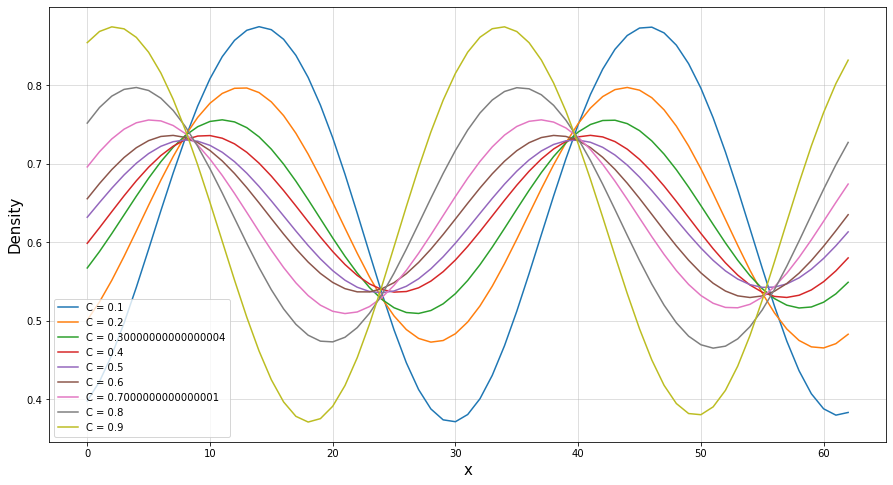

In [15]:
x = np.arange(0,2*np.pi,0.1)
y = np.sin(x)

Cs = np.arange(0.1,1,0.1)

solns = []

for i in range(len(Cs)):
    soln = solve_adv(vals = y,C = Cs[i])
    solns.append(soln.get_vals()[300,:]) # Picking the 300th state in the simulation
    
x = np.arange(len(solns[0]))
plt.figure(figsize = (15,8))
for i in range(len(solns)):
    plt.plot(x,solns[i],label = 'C = {}'.format(Cs[i]))
    
plt.legend()
plt.xlabel('x',size = 15)
plt.ylabel('Density',size = 15)
plt.grid(alpha = 0.5)
# plt.savefig('Large_C_variations.png')

From the above two plots, we can see that large variations to C produce wildly different results, and that even small (0.01!) changes to C results in different wave functions, and that larger values of C quickly lead to a fluid that advects (or smoothens out) more quickly. 

Following the investigation of the convergence of our code relative to the C parameter, I also wanted to investigate how our fluid responds to varying compositions and temperatures. I ivestigated this by taking the equation for conservation of momentum and included the pressure term $\frac{\partial P}{\partial x}$, where pressure is defined as $P = \rho c_s^2$, with $c_s$ being the sound crossing speed of the fluid: $c_s = \sqrt{\frac{k_B T}{\mu m_p}}$. Taking these scalings, I was able to solve for the time dependence of the ith cell in my grid, and vary $\mu$ and T:

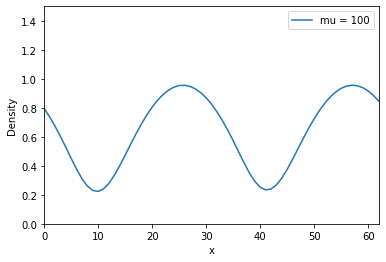

In [22]:
# Varying mu

x = np.arange(0,2*np.pi,0.1)
y = np.sin(x)
mu1 = 100

board = advanced_adv(y,v0 = 10,mu = mu1)

vals = board.get_vals()

n = 0
nt = len(vals)
x = np.arange(len(vals[0]))

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.5))
a0, = ax.plot([], [],label = 'mu = {}'.format(mu1))
plt.legend()
plt.xlabel('x')
plt.ylabel('Density')
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)

HTML(anim.to_html5_video())

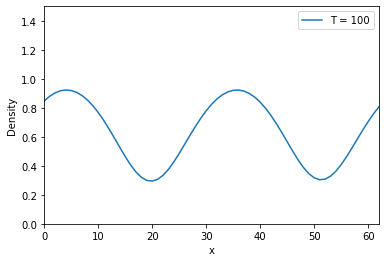

In [23]:
# Varying T

x = np.arange(0,2*np.pi,0.1)
y = np.sin(x)
T1 = 100

board = advanced_adv(y,v0 = 10,T = T1)

vals = board.get_vals()

n = 0
nt = len(vals)
x = np.arange(len(vals[0]))

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.5))
a0, = ax.plot([], [],label = 'T = {}'.format(T1))
plt.legend()
plt.xlabel('x')
plt.ylabel('Density')
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)

HTML(anim.to_html5_video())

Now the movies are cool and fun to look at, but it's hard to gain a qualitative sense for how the fluid is reacting. To gain that more qualitative insight, I plotted how long it took for different runs to reach a max density amplitude of 0.7 with varying $\mu$'s and T's:

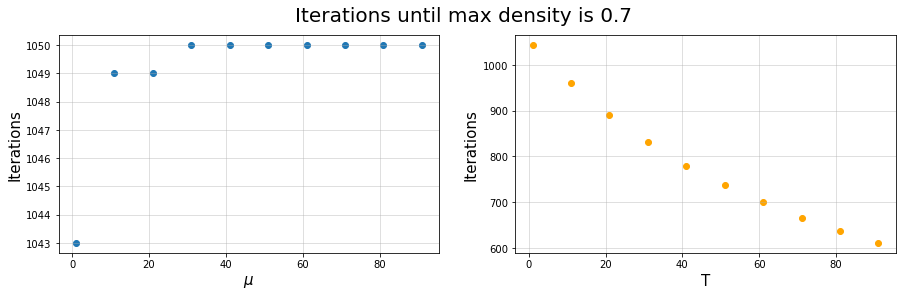

In [21]:
plt.figure(figsize = (15,4))
plt.suptitle('Iterations until max density is 0.7',size = 20)

plt.subplot(121)
plt.scatter(mus,itosmallmu)
plt.xlabel('$\mu$',size = 15)
plt.ylabel('Iterations',size = 15)
plt.grid(alpha = 0.5)

plt.subplot(122)
plt.scatter(Ts,itosmallT,c = 'orange')
plt.xlabel('T',size = 15)
plt.ylabel('Iterations',size = 15)
plt.grid(alpha = 0.5)

We can see here that as $\mu$ gets increasingly large, it becomes less and less relevant to the advection of the fluid, but for $\mu < 30$, small $\mu$ values allow for faster advection. For temeprature, we see that temperature continues to have a significant impact on the advection of the fluid, but this impact varies inversely with increasingly large T. 

##  Conclusion and Perspectives

When I attempted to expand my code to include the pressure (i.e. account for molecular weight and temperature), my solution exploded, gaining the exponential oscillations seen in the naive example. Physically, these parameters should simply change the rate of advection (as the above equaitons and plots show). Numerically, the magntidue of my sound crossing speed was a few orders of magnitude larger than my fluid velocity, making any attempt to plot this process wildly unsuccessful. To get around this, I simply kept the scalings of the sound crossing speed to $\mu$ and T, ignoring the other constants involved, since I'm only really interested in analyzing how the fluid behaves with different compositions and temepratures.

I learned a lot about how hydro code is written, especially when it comes to creating a grid and allowing for the exchange of matter between them. Numerically, there are a lot of approximations that take place to make the code work. In the code that I wrote, I assumed that matter would only be flowing into cell i from the i-1 and the i+1 cells. This put a fundamental limit to how quickly I could evolve the simulation, which led into the discussion of the C parameter and the conditions for convergence. As far as I was able to tell, I could not get my code to reach some definitively true answer. I assumed here that for C ~ 0.1, our solution was close enough to the true solution (which I recognize may or may not be a good assumption). Because of this assumption, I cannot say with confidence how accurate the code I've written here is, though I'm sure more sophisticated code exists that is fairly accurate to real life, even in 1D.

With regard to how $\mu$ and T affect the advection of our fluid, I found that the time dependence of the fluid advection/diffusion depends logarithmically with $\mu$ and inversely with T: 

$$\frac{\partial \rho}{\partial t} \propto log(\mu)$$

and 

$$\frac{\partial \rho}{\partial t} \propto \frac{1}{T}$$


## References

- Dullemond, C.P. “Computational Astrophysics (Studierendentage SS 2018).” Center for Astronomy Heidelberg - Institute of Theoretical Astrophysics, Apr. 2018, https://www.ita.uni-heidelberg.de/~dullemond/lectures/studtage_compastro_2018/index.shtml?lang=en. 

- Mordkiwaustralii. “Morning Fog GIF.” Gfycat, 2 Jan. 2018, https://gfycat.com/uk/carefreescalydodobird. 

- Zingale, Michael, and Ian Hawke. “Python-Hydro/hydro_examples.” GitHub, 2021, https://github.com/python-hydro/hydro_examples. 

- Zingale, Michael. “Stony Brook University.” Introduction to Computational Astrophysical Hydrodynamics, http://bender.astro.sunysb.edu/hydro_by_example/CompHydroTutorial.pdf. 



##  Appendices


### Relevant equations:


#### The advection equation:
\begin{equation}
    \frac{\partial q(x,t)}{\partial t} + \frac{\partial q(x,t)v(x,t)}{\partial x} = s(x,t,q)
\end{equation}

where $q = \rho$ is some density (for example, mass density), and $s = 0$ for the advective equation for conservation of mass, and $q = \rho v$ and $s = -\frac{\partial p}{\partial x} + \rho f$ for the conservation equation of momentum. 

#### Explicitly:
\begin{equation}
    \frac{\partial \rho}{\partial t} + \frac{\partial \rho v}{\partial x} = 0
\end{equation}

\begin{equation}
    \frac{\partial \rho v}{\partial t} + \frac{\partial \rho v^2 + P}{\partial x} = \rho f
\end{equation}

where the pressure P is $P = \rho c_s^2$, and $c_s$ is the isothermal speed of sound: $c_s = \sqrt{\frac{k_B T}{\mu m_p}}$.

#### Naive method:

\begin{equation}
    q_i^{n+1} =  q_i^n - v_0(t_{n+1} - t_n)\frac{q_{i+1}^n - q_{i-1}^n}{x_{i+1} - x_{i-1}}
\end{equation}

#### Upwind method:

For $v_0 > 0$:

\begin{equation}
    q_i^{n+1} =  q_i^n - |v_0|(t_{n+1} - t_n)\frac{q_{i}^n - q_{i-1}^n}{x_{i+1} - x_{i}}
\end{equation}

For $v_0 < 0$:

\begin{equation}
    q_i^{n+1} =  q_i^n - |v_0|(t_{n+1} - t_n)\frac{q_{i}^n - q_{i+1}^n}{x_{i+1} - x_{i}}
\end{equation}

#### Including pressure term:

\begin{equation}
    q_i^{n+1} =  q_i^n - C\frac{(c_s^2 + v_0^2)}{v_0^2}(q_{i+1}^n - q_{i-1}^n)
\end{equation}

#### $c_s$ approximation:

\begin{equation}
    q_i^{n+1} =  q_i^n - C\frac{(\frac{T}{\mu} + v_0^2)}{v_0^2}(q_{i+1}^n - q_{i-1}^n)
\end{equation}